In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

### Load in Cleaned Data

- Discuss Preprocessing and cleaning

### Market Orders (Trades)

In [3]:
trades=pd.read_csv('data/cleaned_trades.csv',index_col=0)


In [41]:
simple_trades=trades[['Exchange','Symbol','Trade_Volume','Trade_Price']].head(1000).copy()
simple_trades

,Exchange,Symbol,Trade_Volume,Trade_Price
2020-01-15 09:30:01.004096,N,AAPL,100,311.94
2020-01-15 09:30:01.100463,N,AAPL,3,311.91
2020-01-15 09:30:01.438061,N,AAPL,10,311.89
2020-01-15 09:30:01.438068,N,AAPL,46,311.89
2020-01-15 09:30:01.677976,N,AAPL,1,311.95
...,...,...,...,...
2020-01-15 10:00:52.113187,N,AAPL,200,315.08
2020-01-15 10:00:53.835758,N,AAPL,10,315.00
2020-01-15 10:00:53.849823,N,AAPL,200,314.95
2020-01-15 10:00:53.865426,N,AAPL,100,315.00


### Limit Orders 

In [42]:
quotes=pd.read_csv('data/cleaned_quotes.csv',index_col=0)


simple_quotes=quotes[['Exchange','Symbol','Bid_Price','Bid_Size','Offer_Price','Offer_Size']].head(2000).copy()
simple_quotes

,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size
2020-01-15 09:30:00.953633,N,AAPL,311.94,1.0,326.18,1.0
2020-01-15 09:30:01.004096,N,AAPL,310.85,1.0,326.18,1.0
2020-01-15 09:30:01.076382,N,AAPL,310.85,1.0,311.96,1.0
2020-01-15 09:30:01.645062,N,AAPL,310.85,1.0,311.95,4.0
2020-01-15 09:30:01.677976,N,AAPL,310.85,1.0,311.95,3.0
...,...,...,...,...,...,...
2020-01-15 09:36:26.934360,N,AAPL,314.00,4.0,314.06,4.0
2020-01-15 09:36:26.951550,N,AAPL,314.00,4.0,314.07,2.0
2020-01-15 09:36:26.982342,N,AAPL,313.81,1.0,314.06,4.0
2020-01-15 09:36:27.009945,N,AAPL,313.81,1.0,314.04,4.0


### Label Direction of Trades

- Utilize Lee-Ready Tick Test for Trade Classification
- Need to review paper and methodology

In [43]:
def label_trade(x,quote_data):

    last_quote=quote_data[quote_data.index<x.name].iloc[-1]
    
    bid_diff=abs(last_quote['Bid_Price']-x['Trade_Price'])
    ask_diff=abs(last_quote['Offer_Price']-x['Trade_Price'])
  


    if ask_diff<bid_diff:
        return 1
    elif bid_diff<ask_diff:
        return -1
    else:
        return 0

simple_trades['side']=simple_trades.apply(lambda x: label_trade(x,simple_quotes),axis=1)
simple_trades

,Exchange,Symbol,Trade_Volume,Trade_Price,side
2020-01-15 09:30:01.004096,N,AAPL,100,311.94,-1
2020-01-15 09:30:01.100463,N,AAPL,3,311.91,1
2020-01-15 09:30:01.438061,N,AAPL,10,311.89,1
2020-01-15 09:30:01.438068,N,AAPL,46,311.89,1
2020-01-15 09:30:01.677976,N,AAPL,1,311.95,1
...,...,...,...,...,...
2020-01-15 10:00:52.113187,N,AAPL,200,315.08,1
2020-01-15 10:00:53.835758,N,AAPL,10,315.00,1
2020-01-15 10:00:53.849823,N,AAPL,200,314.95,1
2020-01-15 10:00:53.865426,N,AAPL,100,315.00,1


In [44]:
side=simple_trades.groupby('side').agg({'Trade_Volume':np.sum})
side

,Trade_Volume
side,
-1,57689
0,350
1,51974


### Label our States

- Spread Tightens or Widens compared to last BBO
- Top of Book Relation to last BBO

In [45]:
simple_quotes['spread']=simple_quotes['Offer_Price']-simple_quotes['Bid_Price']
simple_quotes['last_spread']=simple_quotes['spread'].shift(1)

#label state as 1 or -1 based on widen or tighten
def label_spread(x):
    if x['spread']>x['last_spread']:
        # spread widens
        return 1
    elif x['spread']<x['last_spread']:
        # spread tightens 
        return -1
    else:
        return 0
simple_quotes['spread_state']=simple_quotes.apply(lambda x:label_spread(x),axis=1)


### label relation of top levels
simple_quotes['last_Bid_Price']=simple_quotes['Bid_Price'].shift(1)
simple_quotes['last_Offer_Price']=simple_quotes['Offer_Price'].shift(1)

def label_top_book(x):
    if x['Bid_Price']<x['last_Bid_Price']:
        # top bid decreases
        return 1
    elif x['Bid_Price']>x['last_Bid_Price']:
        # top bid increases 
        return -1
    elif x['Offer_Price']>x['last_Offer_Price']:
        # top ask increases
        return 2
    elif x['Offer_Price']<x['last_Offer_Price']:
        # top ask decreases 
        return -2
    else:
        # no difference
        return 0

simple_quotes['book_state']=simple_quotes.apply(lambda x: label_top_book(x), axis=1)

simple_quotes=simple_quotes.drop(columns=['last_spread','last_Bid_Price', 'last_Offer_Price'])

# embed order flow data; last N seconds of trades

def compute_of(x,trades,freq):

    trades_subset=trades[((pd.to_datetime(trades.index)>pd.to_datetime(x.name)-timedelta(seconds=freq)) & (pd.to_datetime(trades.index)<pd.to_datetime(x.name)))]

    agg_fun={'Trade_Volume':np.sum}
    grouped_trades=trades_subset.groupby('side').agg(agg_fun)
    
    
    if len(grouped_trades.index)<3:
        return 0

    else:
       
        return grouped_trades.loc[1]['Trade_Volume']/(grouped_trades.loc[1]['Trade_Volume']+grouped_trades.loc[-1]['Trade_Volume'])

vals=simple_quotes.apply(lambda x: compute_of(x,simple_trades,60),axis=1)



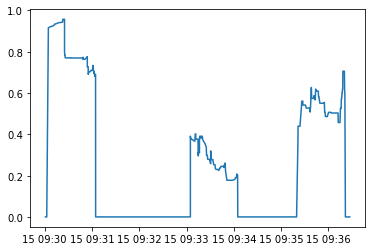

In [47]:
plt.plot(pd.to_datetime(vals.index),vals.values)

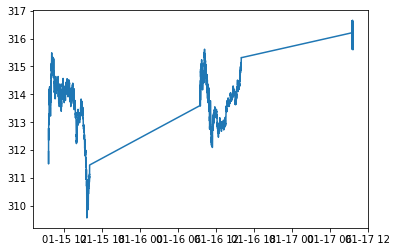

In [49]:
plt.plot(pd.to_datetime(trades.index),trades['Trade_Price'].values)